In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [4]:
device = torch.device('cuda')

In [5]:
base_path = '../models/baseline_base_30_repeat_pe_qknv/'

In [6]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/baseline_base_30_repeat_pe_qknv/checkpoints/184400_0.0620.pt


In [7]:
args = checkpoint['args']

In [8]:
t = tokenizer.Tokenizer(base = args['data']['base'])

In [9]:
args.keys()

dict_keys(['data', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'multi_gpu', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [10]:
model = models.Factorizer(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Factorizer(
  (embedding): TransformerEmbedding(
    (embedding): Embedding(34, 128)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.05, inplace=False)
          (dropout2): Dropout(p=0.05, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
 

# Visualize Embeddings

In [11]:
embeddings = model.embedding.embedding.weight.data.cpu().numpy()

In [12]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['x', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [13]:
embeddings.shape

(34, 128)

In [14]:
tokens.shape

(34,)

In [15]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', 'x', '_', '.', '>'],
      dtype='<U11')

## TSNE
* Doesn't seem to be super interesting (over more paramaters than these)

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

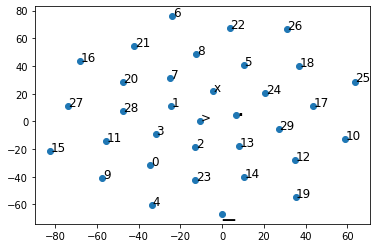

In [18]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

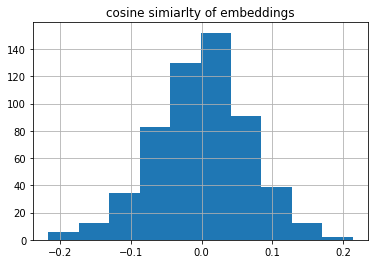

In [28]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [29]:
cs_sim_mat.shape

(34, 34)

In [24]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', 'x', '_', '.', '>'],
      dtype='<U11')

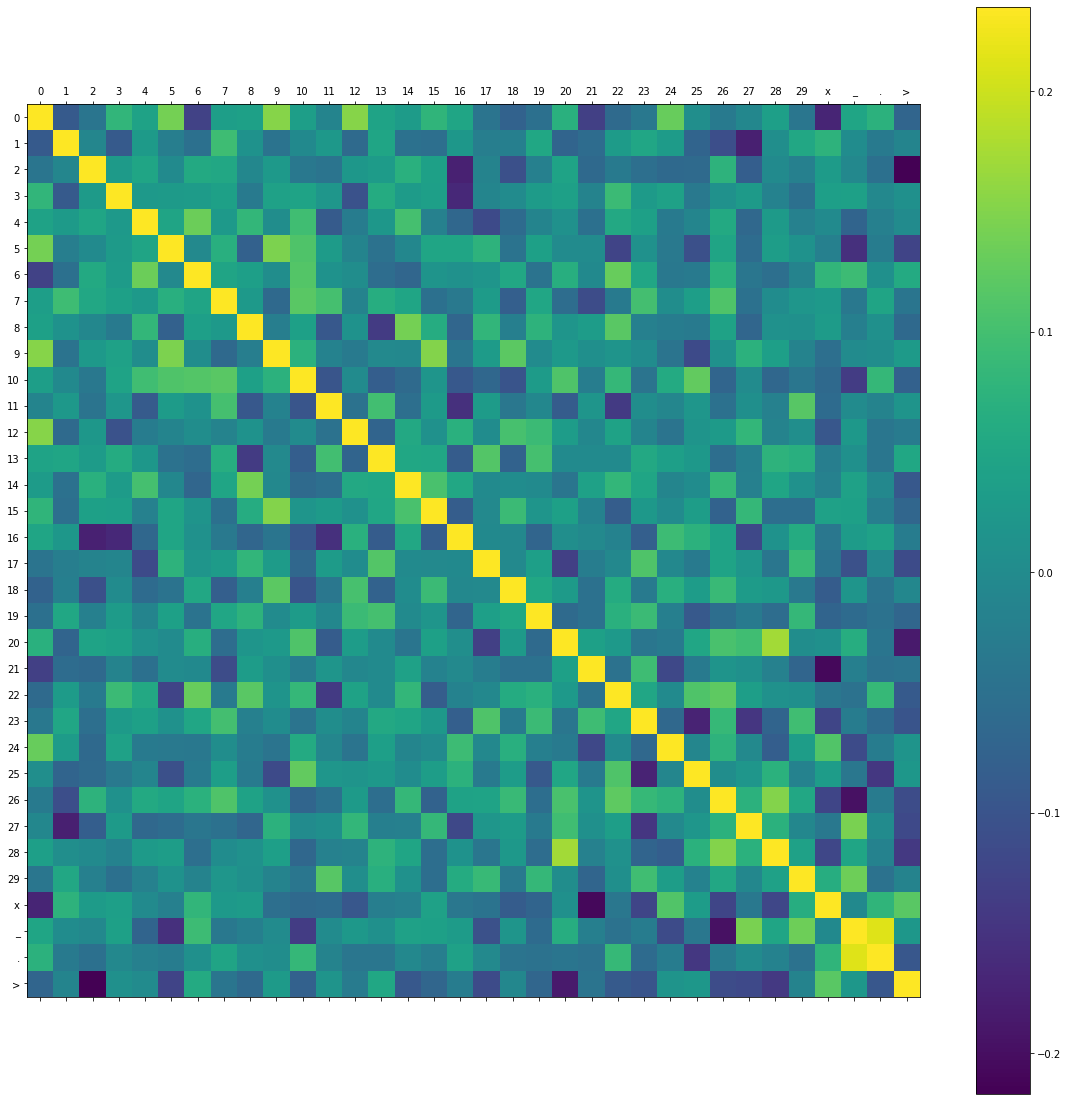

In [30]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(cs_sim_mat, a_min=-1, a_max=cs_sim_mat[cs_sim_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(cs_sim_mat.shape[0]))
ax.set_yticks(np.arange(cs_sim_mat.shape[0]))
ax.set_xticklabels(tokens[:cs_sim_mat.shape[0]])
ax.set_yticklabels(tokens[:cs_sim_mat.shape[0]])
plt.show()

### Are the embeddings linearly predictive of anything interesting?

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [34]:
logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
# logreg = SVC()

In [35]:
embeddings.shape, tokens.shape

((34, 128), (34,))

In [36]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [37]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [38]:
logreg_x_train.shape, logreg_y_train.shape

((20, 128), (20,))

In [39]:
logreg_x_test.shape, logreg_y_test.shape

((10, 128), (10,))

In [40]:
logreg.fit(logreg_x_train, logreg_y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [42]:
logreg.score(logreg_x_train, logreg_y_train)

0.55

In [41]:
logreg.score(logreg_x_test, logreg_y_test)

0.4

# How well does the model do on numbers higher than what it was trained on?

In [43]:
start = 2**16
length = 100
numbers = np.arange(start, start + length)

In [44]:
t

In [45]:
larger_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], numbers, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [46]:
larger_df.shape

(1000, 13)

In [47]:
larger_df.head(5)

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input
0,65536,"[>, 2, 12, 24, 16, .]",0,-1.317986,> 2 x 2 x 2 x 2 x 4 16 1 . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 4081]",65296,5,4,0.8,False,False,False
1,65536,"[>, 2, 12, 24, 16, .]",1,-1.953415,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 7 x 2 11 . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 7, 71]",63616,9,9,1.0,False,False,False
2,65536,"[>, 2, 12, 24, 16, .]",2,-2.859679,> 2 x 2 x 2 x 2 x 7 x 7 x 2 19 . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 7, 7, 79]",61936,7,7,1.0,False,False,False
3,65536,"[>, 2, 12, 24, 16, .]",3,-3.044733,> 2 x 2 x 2 x 2 x 2 x 2 x 1 4 19 . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 1039]",66496,7,7,1.0,False,False,False
4,65536,"[>, 2, 12, 24, 16, .]",4,-3.160079,> 2 x 2 x 2 x 2 x 17 x 7 23 . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 17, 233]",63376,6,6,1.0,False,False,False


In [49]:
larger_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.75
dtype: float64

In [51]:
top_beams = larger_df['beam_idx'] == 9
(larger_df[top_beams]['product'] < larger_df[top_beams]['input_num']).mean()

0.42

### how does it handle squares/cubes/...?

In [53]:
from sympy import factorint
from sympy.ntheory import primerange

In [54]:
max_num = 256
squares = np.array(list(primerange(2, max_num)))**2
cubes = np.array(list(primerange(2, max_num)))**3

In [55]:
square_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], squares, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [56]:
square_df[square_df['beam_idx']==0]['correct_factorization'].mean()

0.5925925925925926

In [60]:
square_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.722222
dtype: float64

In [57]:
cube_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], cubes, args['model_args']['max_decode_size'], postprocess_minimal=True, n_beams = 10)

In [58]:
cube_df[cube_df['beam_idx']==0]['correct_factorization'].mean()

0.14814814814814814

In [61]:
cube_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.203704
dtype: float64

### When encoding two different numbers, what are the cosine similarities of their representations?

In [62]:
first_int = 16
second_int = 32

In [63]:
def get_reps_for_number(number):
    tokens = t.encode(data_utils.form_input(number, args['data']['base']))
    tens = torch.tensor(tokens).unsqueeze(0).to(device)
    memory, _ = model.encode(tens)
    return memory.squeeze().data.cpu().numpy(), tokens

In [64]:
first_reps, first_tokens = get_reps_for_number(first_int)
second_reps, second_tokens = get_reps_for_number(second_int)

In [65]:
cs_sims = cosine_similarity(first_reps, second_reps)

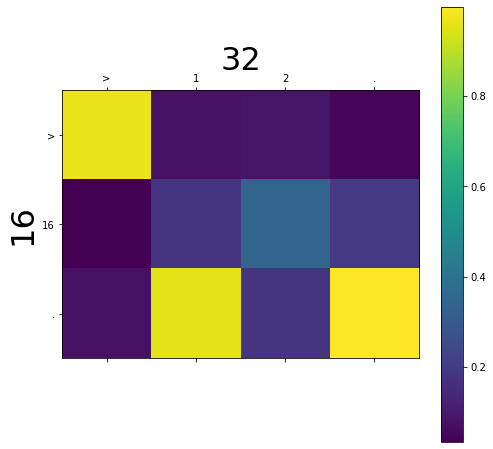

In [74]:
fig = plt.gcf()
fig.set_size_inches(8,8)
ax = plt.gca()
plt.colorbar(ax.matshow(cs_sims), ax=ax)
ax.set_xticks(np.arange(cs_sims.shape[1]))
ax.set_yticks(np.arange(cs_sims.shape[0]))
ax.set_xticklabels(t.decode(second_tokens, decode_special=True).split(' '))
ax.set_yticklabels(t.decode(first_tokens, decode_special=True).split(' '))

plt.xlabel(second_int, fontsize=32)
ax.xaxis.set_label_position('top') 
plt.ylabel(first_int, fontsize=32)

plt.show()

# When the model gets it wrong, what is the probability of the right sequence?

In [75]:
import Levenshtein

In [76]:
target_num = 277337

In [79]:
num_df = metrics_utils.form_factor_df(model, t, device, args['data']['base'], np.array([target_num]), args['model_args']['max_decode_size'], postprocess_minimal=False, n_beams = 10)
num_df['lev_dist'] = num_df.apply(lambda x: Levenshtein.distance(x['pred_str'].replace(' _', ''), x['target_factor_str']), axis=1)
num_df

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite,lev_dist
0,277337,"[>, 10, 8, 4, 17, .]",0,-0.001640,> 10 4 17 . _ _,[9137],9137,1,1,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,9
1,277337,"[>, 10, 8, 4, 17, .]",1,-7.631576,> 9 4 17 . _ _,[8237],8237,1,1,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,10
2,277337,"[>, 10, 8, 4, 17, .]",2,-7.872642,> 7 x 1 14 11 .,"[7, 1331]",9317,2,1,0.5,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,8
3,277337,"[>, 10, 8, 4, 17, .]",3,-8.429690,> 11 x 1 2 7 .,"[11, 967]",10637,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,6
4,277337,"[>, 10, 8, 4, 17, .]",4,-9.211980,> 10 4 17 . _ 27,[274137],274137,1,0,0.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,10
5,277337,"[>, 10, 8, 4, 17, .]",5,-9.211980,> 10 4 17 . _ 22,[274132],274132,1,0,0.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,10
6,277337,"[>, 10, 8, 4, 17, .]",6,-9.211980,> 10 4 17 . _ 20,[274130],274130,1,0,0.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,10
7,277337,"[>, 10, 8, 4, 17, .]",7,-9.211980,> 10 4 17 . _ 21,[274131],274131,1,0,0.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,10
8,277337,"[>, 10, 8, 4, 17, .]",8,-9.211980,> 10 4 17 . _ 3,[274113],274113,1,0,0.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,9
9,277337,"[>, 10, 8, 4, 17, .]",9,-9.211980,> 10 4 17 . _ 2,[274112],274112,1,0,0.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,9


In [80]:
data_utils.form_label(target_num, args['data']['base'])

['>', 15, 13, 'x', 19, 29, '.']

In [81]:
def get_prob_of_factorization(number, factorization):
    tokens = t.encode(data_utils.form_input(number, args['data']['base']))
    tensor_input = torch.tensor(tokens).unsqueeze(0).to(device)
    
    factorization_input = torch.tensor(t.encode(factorization)).unsqueeze(0).to(device)
    
    model_output = torch.softmax(model(tensor_input, factorization_input).squeeze(0), dim=-1)
    
    probs = model_output[torch.arange(model_output.size(0)-1),factorization_input[0,1:]]
    
    return probs.log().sum()

In [84]:
get_prob_of_factorization(target_num, num_df.iloc[0]['target_factor_str'].strip().split(' '))

tensor(-96.3513, device='cuda:0', grad_fn=<SumBackward0>)

In [86]:
torch.tensor(t.encode(num_df.iloc[0]['target_factor_str'].strip().split(' '))).unsqueeze(0).to(device)

tensor([[33, 15, 13, 30, 19, 29, 32]], device='cuda:0')